# Authors:
## Matthias Bartolo                                           Id: 0436103L
## Jerome Agius                                               Id: 0353803L

# Group Project ICS2205 Web Intelligence

## Task 2: Text Analysis

### Challanges encountered through the project:

<ul>
<li>File memory management - Initally when working out the TFIDF this was being kept in memory and thus the program was crashing due to running of of said memory. This was resolved by storing the TFIDF of each word relative to each document in seperate files.

<li>Document name parsing - Some documents had headings which which gave us issues as these had sepcial characters which were being loaded incorrectly. This was resolved by escaping said special characters such that they would be read like any other character.

<li>Get requst parsing - When it came to passing the get request to load the necessary data in each web page, some get requests included the & symbol which we had to convert to %26 so as to pass the get request correctly whilst still having the character present.
</ul>

### Packages

In [1]:
import pandas as pd
import json
import os
import nltk #For tokenisation
from nltk.tokenize import RegexpTokenizer #For tokenising and removing punctuation
from nltk.stem import PorterStemmer #For text Stemming
from nltk.corpus import stopwords #For stop word removal
nltk.download('stopwords')#Downloading stop words from nltk library
import numpy as np
import math
import random
from numpy import dot
from numpy.linalg import norm
import itertools#For dictionary
from operator import add
from collections import OrderedDict#Creates a sorted dictionary (sorted by key)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Creating required directories for output files

In [2]:
isExist = os.path.exists("OutputFiles")
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs("OutputFiles")  
    
isExist = os.path.exists("TFIDF_Doc")
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs("TFIDF_Doc")

### 1. Provide a jupyter notebook that performs the following text analysis tasks on this dataset (Total marks: 60):

### 1.1. Process the news headline text: (14 marks)


#### 1.1 a)  Parse the JSON files, and extract the text from each record (extract the data in “headline” and “short description”.


In [3]:
#Function which extracts the information from the JsonFile
def GetJSONFiles(fileName):
    #List to hold the data
    data=[]
    #Opening file and extracting the data by line
    for line in open(fileName, 'r', encoding="utf8"):
        #If line not equal to \n, then continue to append to the data list
        if line !="\n":
            tmp = json.loads(line)
            tmp['headline'] = tmp['headline'].replace('"','\'')
            data.append(tmp)
    #returning list
    return data

In [4]:
#Retrieving the necessary information from the json file
jsonFiles=GetJSONFiles("NewsCategoryDataset_2017_2022/NewsCategoryDataset_2017_2022.json")

#### 1.1 b)  Perform lexical analyses to extract the separate words, and to fold them all to lower case.


In [5]:
#Function which tokenises the document's content and removes punctuation
def Tokenise(data):
    #Creating reference variable for class RegexpTokenizer, which is found in the nltk class
    tk=RegexpTokenizer(r'\w+')#\w+ is used to match any word character and thus punctuation would be ignored
    #Using tokenise method
    tokenisedDocument=tk.tokenize(data)
    #Returning tokenised document text
    return tokenisedDocument

In [6]:
#Function, which handles case folding, i.e., returns string in list in lowercase
def CaseFolding(textList):
    #Creating and returning new list, whereby, every word is in lowercase
    filteredList=[word.casefold() for word in textList]
    return filteredList

#### 1.1 c)  Use a standard stop-word list for English to filter out the stop words.


In [7]:
#Function which removes stop words (common words) from the english language
def StopWordRemoval(textList):
    #List to hold text without stop words
    filteredList=[]
    #Retrieving stopwords
    stopWords=set(stopwords.words('english'))
    #Looping through all the words in the inputted list, and if they are not stop words, then
    #words are appended to the filtered list
    for word in textList:
        if word not in stopWords:
            filteredList.append(word)
    #Returning filtered List
    return filteredList

#### 1.1 d)  Use an implementation of Porter’s stemmer to reduce terms to their stems (note that you may find a ready-made implementation provided that you reference its source).


In [8]:
#Function which handles Stemming, i.e., removes suffixes and prefixes, from strings in list
def Stemming(textList):
    #Creating reference variable for class PorterStemmer
    stemmer=PorterStemmer()
    #Creating and returning new list, whereby, every word is stemmed
    filteredList =[stemmer.stem(word) for word in textList] 
    #Returning filtered List
    return filteredList

In [9]:
#Function that handles Case-folding, Stop-word removal and Stemming
#by calling all previous functions in the correct order
def DocumentCleaning(text):
    tokenisedList=Tokenise(text)
    casefoldedList=CaseFolding(tokenisedList)
    stopwordRemovedList=StopWordRemoval(casefoldedList)
    stemmedList=Stemming(stopwordRemovedList)
    return stemmedList

In [10]:
#Function, which calls all previous functions, and returns a filtered list of all the documents
def DocumentIndexing(fileData):
    #Document list to hold all the text in all documents
    documentList={}
    
    tmpCntr = 0
    #Loooping through every file
    for file in fileData:
        #Cleaning extractedData
        cleanedData1=DocumentCleaning(file["headline"])
        cleanedData2=DocumentCleaning(file["short_description"])      
        #Appending cleaned data to document list
        documentList[tmpCntr]=cleanedData1+cleanedData2
        tmpCntr+=1
        
    #Returning documentList
    return documentList

In [11]:
#Retrieving the filtered list of documents 
documentList=DocumentIndexing(jsonFiles)

### 1.2. Calculate term weights using TF.IDF. Each headline record should be considered as a single document. (8 marks)

In [12]:
#Function which returns all the unique words in all of the documents
def GetUniqueWords(documentList):
    #Dictionary to hold the frequency of every word (utilised for fast indexing)
    wordFrequency={}
    
    #Looping through the text in the list, and if word is not present in wordFrequency dictionary,
    #then word will be added to dictionary with frequency of 1, else if word is present
    #frequency will be incremented    
    for docIndex in documentList.keys():
        for word in documentList[docIndex]:
            if word not in wordFrequency.keys():
                wordFrequency[word]=1
            else:
                wordFrequency[word]+=1
                
    #Returning list
    return wordFrequency

In [13]:
#Function which calculates the inverse document frequency values of TF.IDF weight
def GetInverseDocumentFrequency(WordFreqList,documentList):
    #Dictionary to hold the inverse document frequency
    inverseDocumentfrequency={}
    
    #Looping through all the words in the WordFreqList.keys()
    for word in WordFreqList.keys():
        #Variable to act as a counter, to count the number of documents, word appears in
        documentAppearsCounter=0
        
        tmpCntr = 0
        #Looping through all the documents in the documentList
        for docIndex in documentList.keys():
            #If word is in document, then incrementing the counter
            if word in documentList[docIndex]:
                documentAppearsCounter+=1
            tmpCntr+=1
        #Calculating inverse document frequency by taking the log((no of documents)/(no of documents containing the word)) 
        inverseDocumentfrequency[word]=math.log((len(documentList.keys())/(documentAppearsCounter)),10) 
    #Returning inverse document frequency
    return inverseDocumentfrequency

In [14]:
#Function which calculates the TFIDF values for each word in each document
def GetTFIDFCombinedIndividualFiles(WordFreqList, documentList, IDFValues):    
    for docIndex in documentList.keys():
        print("Doc ", docIndex,": ",jsonFiles[docIndex]["headline"])
        #Opening the file in which the TFIDF for each word is going to be saved
        with open("TFIDF_Doc/"+str(docIndex)+".json", "w", encoding="UTF-8") as TFIDF_File:
            #Writing to the file scuh that the data would be in the correct format
            TFIDF_File.write('{')
            TFIDF_File.write('\"')
            #Escaping the \ character due to headlines containign said character
            tmpHealine = jsonFiles[docIndex]["headline"].replace('\\','\\\\')
            TFIDF_File.write(tmpHealine)
            TFIDF_File.write('":')
            
            #Constructing the array containing the term frequencies for the words
            WordTFVector = {}
            
            #For each unique word present in the document working out its TF 
            for word in WordFreqList.keys():
                WordTFVector[word] =(documentList[docIndex].count(word))
            
            #Choosing the appropriate divisor for normalisation
            divisor = max(WordTFVector.values())
            
            #Normalising the TF found previously & working out the TFIDF
            for word in WordFreqList.keys():
                WordTFVector[word] = WordTFVector[word]/divisor*IDFValues[word]
            
            #Writing the contents of the WordTFVector to file
            json.dump(WordTFVector, TFIDF_File)
            
            #Breaking when all the documents have been considered
            if(docIndex < len(documentList.keys())):
                TFIDF_File.write("}\n")
            else:
                TFIDF_File.write('}\n')
                break
        #Closing the file as it's no longer required         
        TFIDF_File.close()

In [15]:
#Retrieivng the word frequency list 
sortedWordFreqList=GetUniqueWords(documentList)

In [16]:
#Working out the IDF for all the unique words
IDFValues = GetInverseDocumentFrequency(sortedWordFreqList,documentList)

In [3]:
#Working out the TFIDF for the entire set of documents and storing the data in the TFIDF_Doc directory

#Note: In relation to working out the TF.IDF, we are sacrificing time optimality by storing some data into files so as to gurantee
#that the program works on a variety of computers irrelevant of the hardware used. This is because different computers might 
#have varying sizes of Random Access Memory, and thus by storing the data in files we ensure that memory will no longer pose 
#any issues. Due to the Disk Serialization processs, the program requires a degree of free storage on disk (aprox 20gb). 
#Usually computers come equipped with sufficient secondary storage and thus, the large file size should not pose any issues 
#to the user. 

GetTFIDFCombinedIndividualFiles(sortedWordFreqList,documentList,IDFValues)

In [19]:
#Working out the top words for each document according to the TFIDF of each word

#The numberOfTerms was set to 50 terms only as their are a large numebr of terms across all the documents around 
#27k thus even 1% was retrieving a large degree of words which was deemed unnecessary 
numberOfTerms  = 50#int(0.01*len(sortedWordFreqList))

#Retrieving the unique list of words
words = list(sortedWordFreqList.keys())

#Dictionary to store the top words of all the documents 
docTopWords = {}

#Dictionary to store the entire data in relation to all the documents
documentData = {}

#Looping throguh all the documents in the documentList
for docIndex in documentList.keys():
    #Opening the file containing the necessary document data
    with open("TFIDF_Doc/"+str(docIndex)+".json", 'r', encoding="UTF-8") as f:
        #Reading the data from file
        docInfo = json.loads(f.read())
        
        #Sorting the retrieved data and converting it to dictionary data type   
        docInfo = dict(sorted(docInfo[jsonFiles[docIndex]["headline"]].items(), key=lambda item: item[1], reverse=True))
        
        #Removing the extra words form the dictionary 
        docTopWords[docIndex]=dict(itertools.islice(docInfo.items(), numberOfTerms))
    
    #Closing the file as it's no longer required 
    f.close()
    
    #Adding the necessary data to the document dictionary
    document = {}
    document["headline"] = jsonFiles[docIndex]["headline"]
    document["short_description"] = jsonFiles[docIndex]["short_description"]
    document["authors"] = jsonFiles[docIndex]["authors"]
    document["category"] = jsonFiles[docIndex]["category"]
    document["date"] = jsonFiles[docIndex]["date"]
    document["link"] = jsonFiles[docIndex]["link"]

    #Retrieving the top words and their tf.idf values
    document["topWords"] = list(docTopWords[docIndex].keys())
    document["topWordValues"] = list(docTopWords[docIndex].values())
    documentData[str(docIndex)] = document

#Saving the previously found data to file
with open("OutputFiles/topWords.json", "w+") as outfile:
    json.dump(documentData, outfile, sort_keys=True)

### 1.3.  Extract the highest-weighted n% of the terms for each headline category (each JSON record has a field called “category”). (14 marks) 
### This can be split as follows:


#### 1.3 a) Calculate the average term weight for all terms over the documents within each category


In [18]:
documentCategories={}
#Looping through contents of JsonFile and appending the headline and short_description to the documentCategories dictionary
for line in jsonFiles:
    if line["category"] not in documentCategories.keys():
        documentCategories[line["category"]]={line["headline"]:line["short_description"]}
    else:
        documentCategories[line["category"]].update({line["headline"]:line["short_description"]})

In [19]:
#Function, which calls a series of previously defined functions, and returns a filtered list of words for each category
def DocumentCategoryCleaning(CategoriesWordList):
    #Document list to hold all the text in all documents
    documentList={}
    for CategoryData in CategoriesWordList.keys():
        cleanedData=[]
        for item in CategoriesWordList[CategoryData]:
            cleanedData1=DocumentCleaning(item)
            cleanedData2=DocumentCleaning(CategoriesWordList[CategoryData][item])      
            cleanedData+=cleanedData1+cleanedData2
        documentList[CategoryData]=cleanedData
        
    #Returning documentList
    return documentList

In [20]:
#Retrieving the list of words present in each category
listOfWordsInEachCategory=DocumentCategoryCleaning(documentCategories)

In [21]:
#Retrieving the word frequency list across all categories
sortedWordFreqList2=GetUniqueWords(listOfWordsInEachCategory)

Getting UniqueWords


In [4]:
#Working out the IDF for all the unique words in each category
IDFValues2=GetInverseDocumentFrequency(sortedWordFreqList2,listOfWordsInEachCategory)

In [23]:
#Function which calculates the TFIDF values for each word in each category
def GetTFIDFCombinedIndividualCategory(WordFreqList,listOfWordsInCategory, IDFValues):
    CatDict = {}
    #Looping through all the unique categories
    for category in listOfWordsInCategory.keys():
        print("Category: ", category)

        #Constructing the dictionary containig the term frequncies for each word
        WordTFVector = {}

        #For each category working out the tf of the specified word and appending it
        for word in set(listOfWordsInCategory[category]):
            WordTFVector[word] =(listOfWordsInCategory[category].count(word))

        #Choosing the appropriate divisor for normalisation
        divisor = max(WordTFVector.values())
        
        #Normalising the TF found previously & working out the TFIDF
        for word in set(listOfWordsInCategory[category]):
            WordTFVector[word] = WordTFVector[word]/divisor*IDFValues[word]
        
        #Storing the contents of the WordTFVector to dictionary
        CatDict[category] =  WordTFVector
    return CatDict

In [5]:
#Working out the TFIDF for the entire set of documents and storing the data in CatDict
CatDict = GetTFIDFCombinedIndividualCategory(sortedWordFreqList2,listOfWordsInEachCategory,IDFValues2)

#### 1.3 b) Get the highest-weighted n% of the terms for each category. This list of terms, and their corresponding weights will subsequently be used to build a category keyword-cloud. This keyword-cloud will show what concepts each category generally mentions. n can be determined arbitrarily so that the keyword-cloud will contain neither too much nor too few words.

In [25]:
#Function which retrieves the n% of terms in each category
def GetNTermsCategory(CatDict, docCategoryList, percentage):
    #Dicitorany to store the topwords in each category
    CatContents = {}
    
    #Looping through each unique category 
    for category in docCategoryList.keys():
        #Determining the number of terms to retrieve per category
        numberOfTerms = int(percentage*len(CatDict[category]))
        
        #Sorting the retrieved data and converting it to dictionary data type 
        sortedCategoryWords = dict(sorted(CatDict[category].items(), key=lambda item: item[1], reverse=True))
        
        #Removing the extra words from the dictionary 
        CatContents[category] = dict(itertools.islice(sortedCategoryWords.items(), numberOfTerms))
    return CatContents

In [26]:
#Working out the top words for each category according to the TFIDF of each word (20% in this case)
TopWordsPerCat = GetNTermsCategory(CatDict, documentCategories, 0.2)

#### 1.3 c) Extract the details of each category (including the category name, the list of articles in it, and list of highest-weighted terms for each category) as JSON. This will be used in the visualisation application described below.

In [27]:
#Function which retrieves the details of each category
def GetCategoryDetails(TopWordsPerCat, docCategoryList):
    #Dictionary to store the required data for each category
    FinalDict = {}
    
    #Opening the necessary file to store data 
    with open("OutputFiles/TFIDF_Category.json", "w", encoding="UTF-8") as Cat_File:
        
        #Looping through the unique categories and storing the articles that appear and the top words present in said categories   
        for category in docCategoryList.keys():
            tmp = {}
            tmp["weights"] =  TopWordsPerCat[category]
            
            articles={}
            count=1
            for document in docCategoryList[category].keys():
                articles[count] = document
                count+=1
            tmp["articles"] = articles
            
            FinalDict[category] = tmp
        
        #Storing the data retrieved above in file 
        json.dump(FinalDict, Cat_File, sort_keys=True, indent=4)
        
        #Closing the file as it's no longer required    
        Cat_File.close()

In [28]:
#Working out the documents and the top words for each category according to the TFIDF of each word
GetCategoryDetails(TopWordsPerCat, documentCategories)

### 1.4. Use the document vectors to cluster the news headlines using the k-means algorithm. The choice of k is up to you. Note that you only need to do a single level of clustering, that is, no hierarchies are being requested. (12 marks)


In [17]:
#Function which calculates, the similarity between the query and each document
def CosineSimilarity(documentVector,centroidVector): 
    #Calculating dot product
    dotproduct=dot(list(documentVector),list(centroidVector))
    #Calculating Cosine Similarity
    cosSimilarity = dotproduct / (norm(list(documentVector)) * norm(list(centroidVector)))
    
    #Returning the cosine similarity value
    return round(cosSimilarity,3)

In [6]:
#Determining the number of clusters in which to place the documents
noOfClusters = 5

#List to hold the vector that represents each centroid 
PreviousSelectedCentroids = []
SelectedCentroidsIndex = []
SelectedCentroids = []

#Selecting the inital centroids at random 
for x in range(noOfClusters):
    clusterIndex = random.randint(0,len(jsonFiles)-1)
    
    #Making sure the choosen centroid is unique 
    while clusterIndex in list(SelectedCentroidsIndex):
        clusterIndex = random.randint(0,len(jsonFiles)-1)
    
    #Appending the choosen cluster to the list of selected centroids
    SelectedCentroidsIndex.append(clusterIndex) 

#Retrieving the data associated with each centroid so as to compare the other data to, 
#to work out the similarity to a cluster centroid 
for docIndex in SelectedCentroidsIndex:
    with open("TFIDF_Doc/"+str(docIndex)+".json", "r", encoding="UTF-8") as TFIDF_File:
        SelectedCentroids.append(json.loads(TFIDF_File.read())[jsonFiles[docIndex]["headline"]].values())

clusters = {}
#tart is used to force the loop to run at least once
start = False

#clusterSwap is used to indicate that a cluster was changed and thus they haven't converged 
clusterSwap=False

#Stores the old cluster locations to facilitate comparison between this and the 
#subsequent cluster contents to see if they converged or not 
oldClusters={}

#Counter is used to force the algorithm to stop after a set number of iterations (5) 
#as otherwise it would take too long to converge. 5 was choosen as although the 
#algorithm would work fine with a larger number it would take too long to termiante 
#and we didn't have the time required to do so.  
counter = 1
while start==False or clusterSwap==True:
    clusterSwap=False
    print("Iteration: ", counter)
    #Looping through all the documents
    for docIndex in documentList.keys():
        print("Doc being assigned ", docIndex,": ",jsonFiles[docIndex]["headline"])
        #Retrieving the data required from the respective files
        with open("TFIDF_Doc/"+str(docIndex)+".json", "r", encoding="UTF-8") as TFIDF_File:
            #Loading the required data
            currDoc = json.loads(TFIDF_File.read())[jsonFiles[docIndex]["headline"]].values()
            #List to hold the distances of the current document to all the centroids
            docCentroidDist = []
            
            #Determing the similarity between the document and the centroids
            for centroid in SelectedCentroids: 
                docCentroidDist.append(round(CosineSimilarity(currDoc,centroid),2))
            
            #Determining the centroid to which the file is most similar
            bestCentroidIndex = docCentroidDist.index(max(docCentroidDist))
            
            #Appending the data to the clusters dictionary 
            if(bestCentroidIndex not in clusters.keys()):
                clusters[bestCentroidIndex] = [docIndex]
            else:
                clusters[bestCentroidIndex].append(docIndex)
            
    #Calculating the new centroid values (i.e., the new centroid positions)
    newCentroids=[]
    #Looping through all the documents associated to a cluster
    for docIndex in clusters:
        total=[]
        #Opening the necessary files and retrieving the required data to work out the new cluster values
        with open("TFIDF_Doc/"+str(docIndex)+".json", "r", encoding="UTF-8") as TFIDF_File:
            currDoc = json.loads(TFIDF_File.read())
            currData = currDoc[jsonFiles[docIndex]["headline"]]
            
            #Assigning the new values to the total list 
            if(total==[]):
                total=currData
            else:
                total=[total[key]+currData[key] for key in currData.keys()]
        
        #Appending the new values to the newCentroids dict 
        newCentroids.append([total[key]/len(clusters) for key in total.keys()])
    
    clusters = dict(OrderedDict(sorted(clusters.items())))
    
    #Incrementing the counter to signal that anotehr loop has completed
    counter+=1
    
    #Copying the newCentroids data into SelectedCentroids
    SelectedCentroids = newCentroids.copy()
    
    #Stopping condition for the algorithm
    if(oldClusters==clusters or counter > 5):
        break
    elif(oldClusters!=clusters or start==False):
        oldClusters = {}
        oldClusters=clusters.copy()
        clusters = {}
        clusterSwap=True   
    start=True    

### 1.5. Extract the highest-weighted n% of the terms for each cluster generated in the previous step. (12 marks)
### This can be split as follows:


#### 1.5 a) Calculate the average term weight for all terms over the documents within each cluster.

In [19]:
documentClusters={}
#Looping through contents of JsonFile and appending headline and short_description to extractedText list
for clusterNo in clusters.keys():
    for docIndex in clusters[clusterNo]:
        if clusterNo not in documentClusters.keys():
            documentClusters[clusterNo]={jsonFiles[docIndex]["headline"]:jsonFiles[docIndex]["short_description"]}
        else:
            documentClusters[clusterNo].update({jsonFiles[docIndex]["headline"]:jsonFiles[docIndex]["short_description"]})

In [20]:
#Function, which calls all previous functions, and returns a filtered list of all the documents
#Method is the same as above but names/variables changed to make it general and combine them
def DocumentClusterCleaning(ClustersWordList):
    #Document list to hold all the text in all documents
    documentList={}
    for ClusterData in ClustersWordList.keys():
        cleanedData=[]
        for item in ClustersWordList[ClusterData]:
            cleanedData1=DocumentCleaning(item)
            cleanedData2=DocumentCleaning(ClustersWordList[ClusterData][item])      
            cleanedData+=cleanedData1+cleanedData2
        documentList[ClusterData]=cleanedData
        
    #Returning documentList
    return documentList

In [21]:
#Retrieving the list of words present in each cluster
listOfWordsInEachCluster = DocumentClusterCleaning(documentClusters)

In [22]:
#Working out the sorted word frequency list
sortedWordFreqList3=GetUniqueWords(listOfWordsInEachCluster)

In [23]:
#Working out the IDF for all the unique words in each category
IDFValues3=GetInverseDocumentFrequency(sortedWordFreqList3,listOfWordsInEachCluster)

In [24]:
#Function which calculates the TFIDF values for each word in each cluster
def GetTFIDFCombinedIndividualCluster(WordFreqList,listOfWordsInEachCluster, IDFValues):
    ClustDict = {}
    
    #Looping through all the unique clusters
    for cluster in listOfWordsInEachCluster.keys():

        #Constructing the dictionary containig the term frequncies for the current cluster
        WordTFVector = {}

        #For each cluster working out the tf of the specified word and appending it
        for word in set(listOfWordsInEachCluster[cluster]):
            WordTFVector[word] =(listOfWordsInEachCluster[cluster].count(word))
        
        #Choosing the appropriate divisor for normalisation
        divisor = max(WordTFVector.values())
        
        #Normalising the TF found previously & working out the TFIDF
        for word in set(listOfWordsInEachCluster[cluster]):
            WordTFVector[word] = WordTFVector[word]/divisor*IDFValues[word]
        
        #Storing the contents of the WordTFVector to dictionary
        ClustDict[cluster] =  WordTFVector
    return ClustDict

In [25]:
#Working out the TFIDF for the entire set of documents and storing the data in ClustDict
ClustDict = GetTFIDFCombinedIndividualCluster(sortedWordFreqList3,listOfWordsInEachCluster,IDFValues3)

#### 1.5 b) Get the highest-weighted n% of the terms for each cluster. This list of terms, and their corresponding weights will subsequently be used to build a cluster keyword-cloud. This keyword-cloud will show what concepts each cluster generally mentions. n can be determined arbitrarily so that the keyword-cloud will contain neither too much nor too few words

In [26]:
#Function which retrieves the n% of terms in each cluster
def GetNTermsCluster(ClustDict, docClustersList, percentage):
    #Dicitorany to store the topwords in each cluster
    ClusterContents = {}
    
    #Looping through each unique cluster 
    for cluster in docClustersList.keys():
        #Determining the number of terms to retrieve per cluster
        numberOfTerms = int(percentage*len(ClustDict[cluster]))
        
        #Sorting the retrieved data and converting it to dictionary data type 
        sortedClusterWords = dict(sorted(ClustDict[cluster].items(), key=lambda item: item[1], reverse=True))
        
        #Removing the extra words from the dictionary 
        ClusterContents[cluster] = dict(itertools.islice(sortedClusterWords.items(), numberOfTerms))
    return ClusterContents

In [27]:
#Working out the top words for each cluster according to the TFIDF of each word (20% in this case)
TopWordsPerCluster = GetNTermsCluster(ClustDict, documentClusters, 0.2)

#### 1.5 c) Extract the details of each cluster (the cluster ID, the list of articles in it, and list of highest-weighted terms for each cluster) as JSON. This will be used in the visualisation application described below

In [28]:
#Function which retrieves the details of each cluster
def GetClusterDetails(TopWordsPerCluster, docClustersList):  
    #Dictionary to store the required data for each category
    FinalDict = {}
    
    #Opening the necessary file to store data 
    with open("OutputFiles/TFIDF_Cluster.json", "w", encoding="UTF-8") as Cluster_File:
        
        #Looping through the unique clusters and storing the articles that appear and the top words present in said cluster   
        for cluster in docClustersList.keys():
            tmp = {}
            tmp["weights"] =  TopWordsPerCluster[cluster]
            
            articles={}
            count=1
            for document in docClustersList[cluster].keys():
                articles[count] = document
                count+=1
            tmp["articles"] = articles
            
            FinalDict[cluster] = tmp
            
        #Storing the data retrieved above in file 
        json.dump(FinalDict, Cluster_File, sort_keys=True, indent=4)
        
        #Closing the file as it's no longer required 
        Cluster_File.close()

In [29]:
#Working out the documents and the top words for each cluster according to the TFIDF of each word
GetClusterDetails(TopWordsPerCluster, documentClusters)

# Flask setup

To run the below webpage one requires python flask to be installed. If not installed this can be done via the following command: "pip install Flask".
The required files must also be present, these being the topWords.json/TFIDF_Category.json/TFIDF_Cluster.json and placed in the outputFiles directory.
Furhtermore these files can be obtained by running the above program. (An instance of these files has been provided for testing purposes)

Moreover, the static folder provided with the project zip along with its contents must be placed in the same directory as the .ipynb file
The templates folder provided with the project zip along with its contents must be placed in the same directory as the .ipynb file

<u>Sources used:</u>

Bubble Chart: https://www.webtips.dev/how-to-make-interactive-bubble-charts-in-d3-js

WordCloud visualisation: https://github.com/wvengen/d3-wordcloud     

To open the website run the code below and click on the link generated

### 2 Set up a simple web application that can visualise the results obtained. Namely, you need to (Total marks: 40):
#### a. Set up a simple web application using Flask. (10 marks). This involves the following:
#### i. Set up Flask.
#### ii. Import the JSON files generated in the Text Analysis part.

In [ ]:
import os
from flask import Flask, render_template, json, current_app as app

#Setting up a flask application
app = Flask(__name__)

#Opening the corresponding files and parsing their data as json 
with open('OutputFiles/topWords.json', 'r') as file:
     tpf = json.load(file)

with open('OutputFiles/TFIDF_Category.json', 'r') as file1:
    opf = json.load(file1)   

with open('OutputFiles/TFIDF_Cluster.json', 'r') as file2:
    opf2 = json.load(file2)  
    
#Specifiying the url extensions for each website section
#Default route loads to the main page 
@app.route('/', methods = ['GET', 'POST'])
def loadData():
    return render_template('index.html',tpf=tpf, opf=opf, opf2=opf2)

#/docInfo loads the document Info page displaying content retrieved above
@app.route('/docInfo', methods = ['GET', 'POST'])
def loadInfo():
    return render_template('docInfo.html',tpf=tpf)

#/catInfo loads the category Info page displaying content retrieved above
@app.route('/catInfo', methods = ['GET', 'POST'])
def loadInfo2():
    return render_template('categoryInfo.html',opf=opf)

#/clustInfo loads to cluster Info page displaying content retrieved above
@app.route('/clustInfo', methods = ['GET', 'POST'])
def loadInfo3():
    return render_template('clusterInfo.html', opf2=opf2)

#Launching the website
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Jan/2023 19:52:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Jan/2023 19:52:36] "GET /docInfo?docIndex=9994 HTTP/1.1" 200 -
127.0.0.1 - - [20/Jan/2023 19:52:46] "GET /catInfo?parameter=CULTURE%20%26%20ARTS HTTP/1.1" 200 -
127.0.0.1 - - [20/Jan/2023 19:52:53] "GET /clustInfo?parameter=3 HTTP/1.1" 200 -


#### iii. Show the list of documents as a ‘clickable’ list.

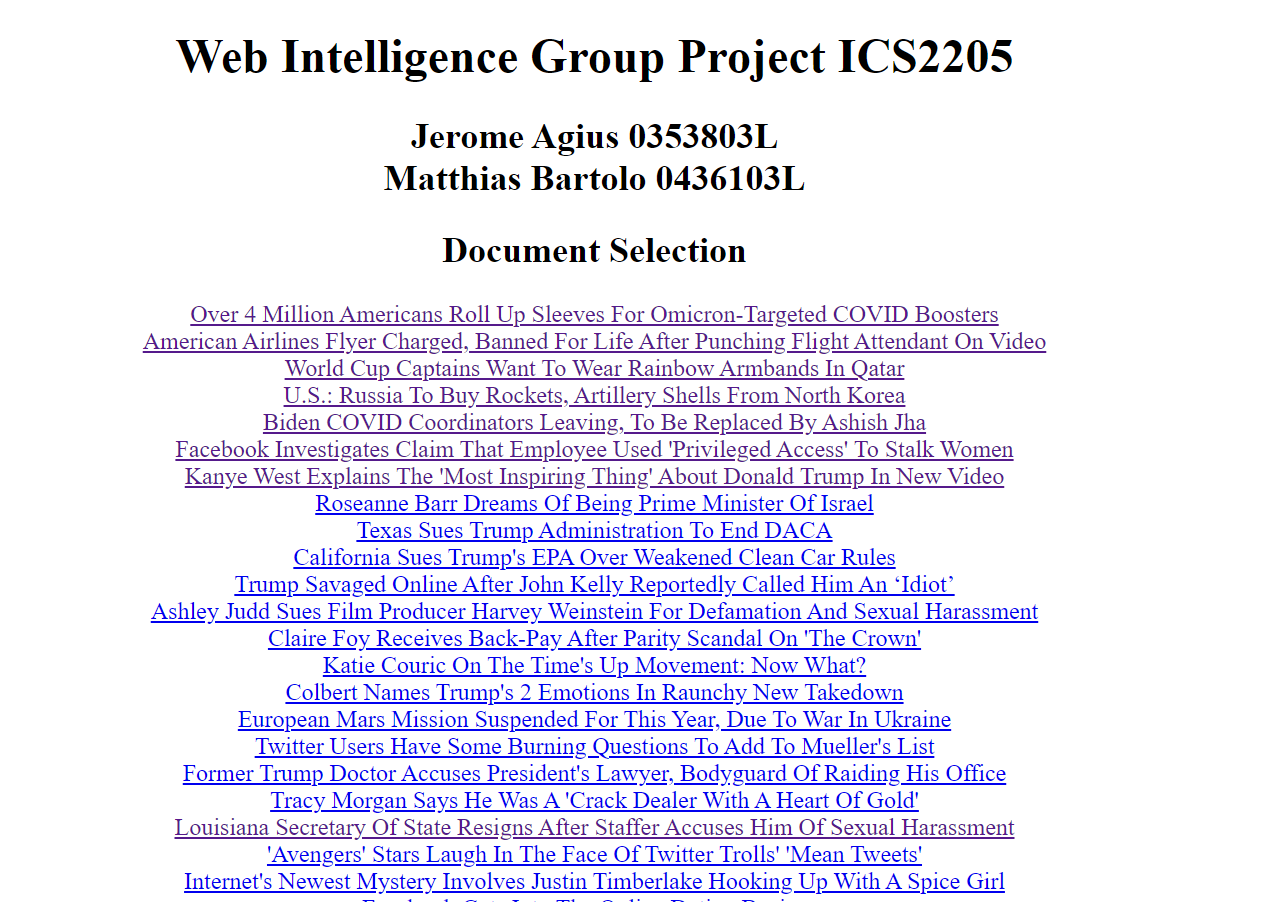

#### b. When a document is clicked, its details (headline, date, etc) and the corresponding keyword cloud should be shown. (10 marks)

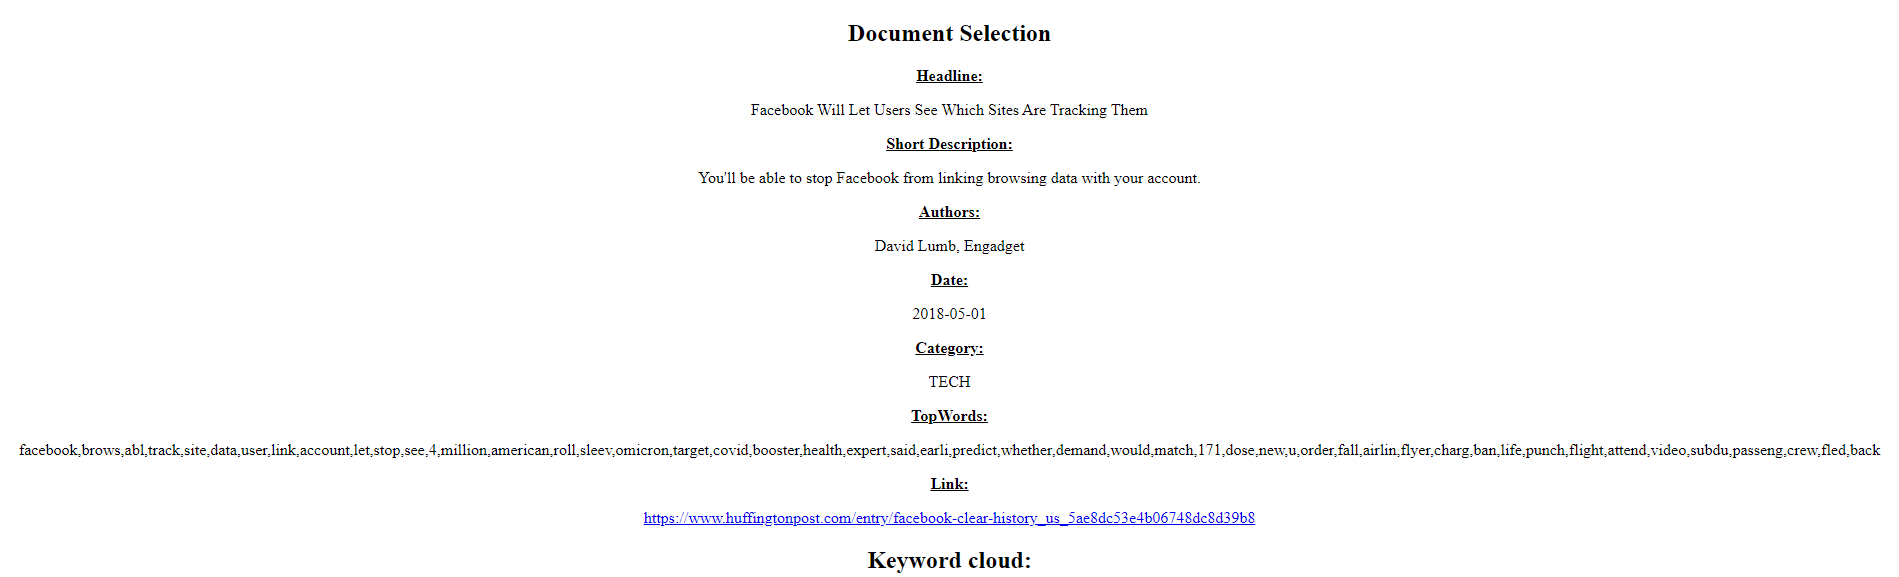

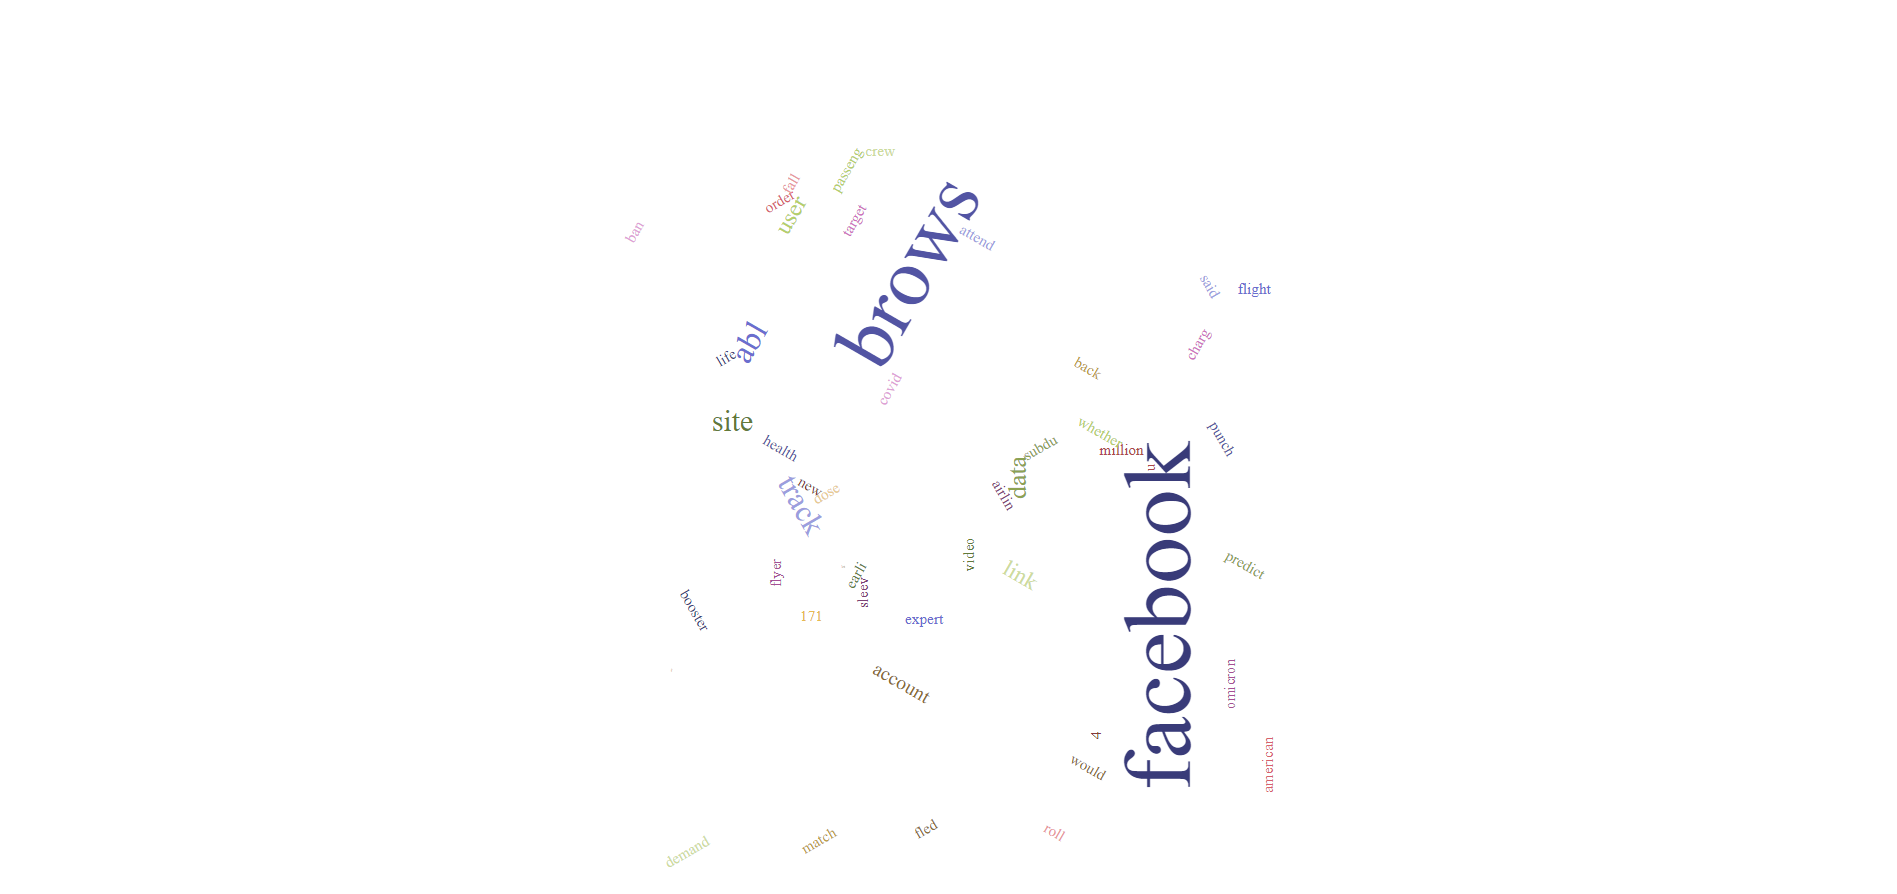

#### c. Show the list of categories as an interactive bubble chart. When a category bubble is clicked, the list of documents which who form part of that category should be shown together with the keyword cloud for that category. (10 marks)

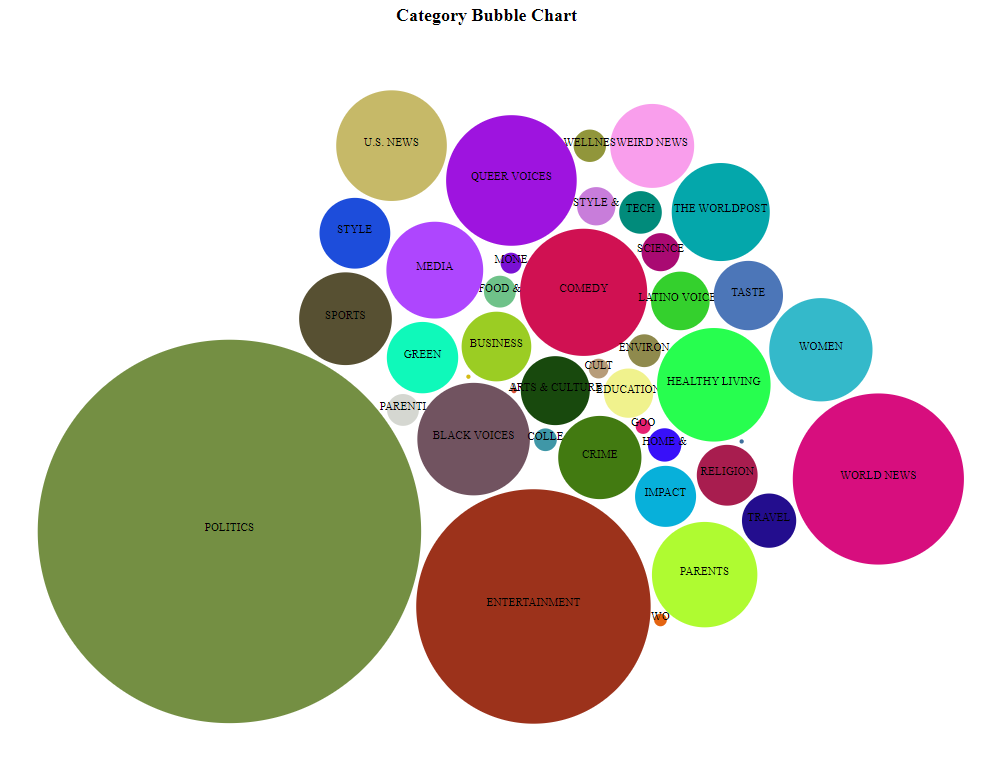

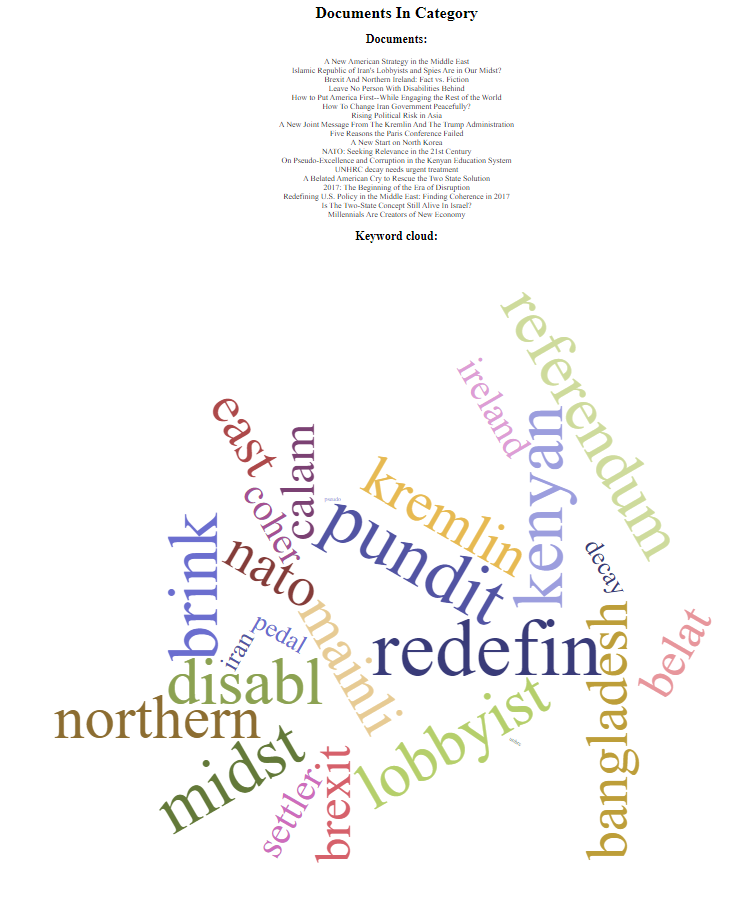

#### d. Show the terms’ clusters as an interactive bubble chart (similar to point c above). When a cluster bubble is clicked, the list of documents which who form part of that category should be shown together with the keyword cloud for that cluster should be shown. (10 marks)

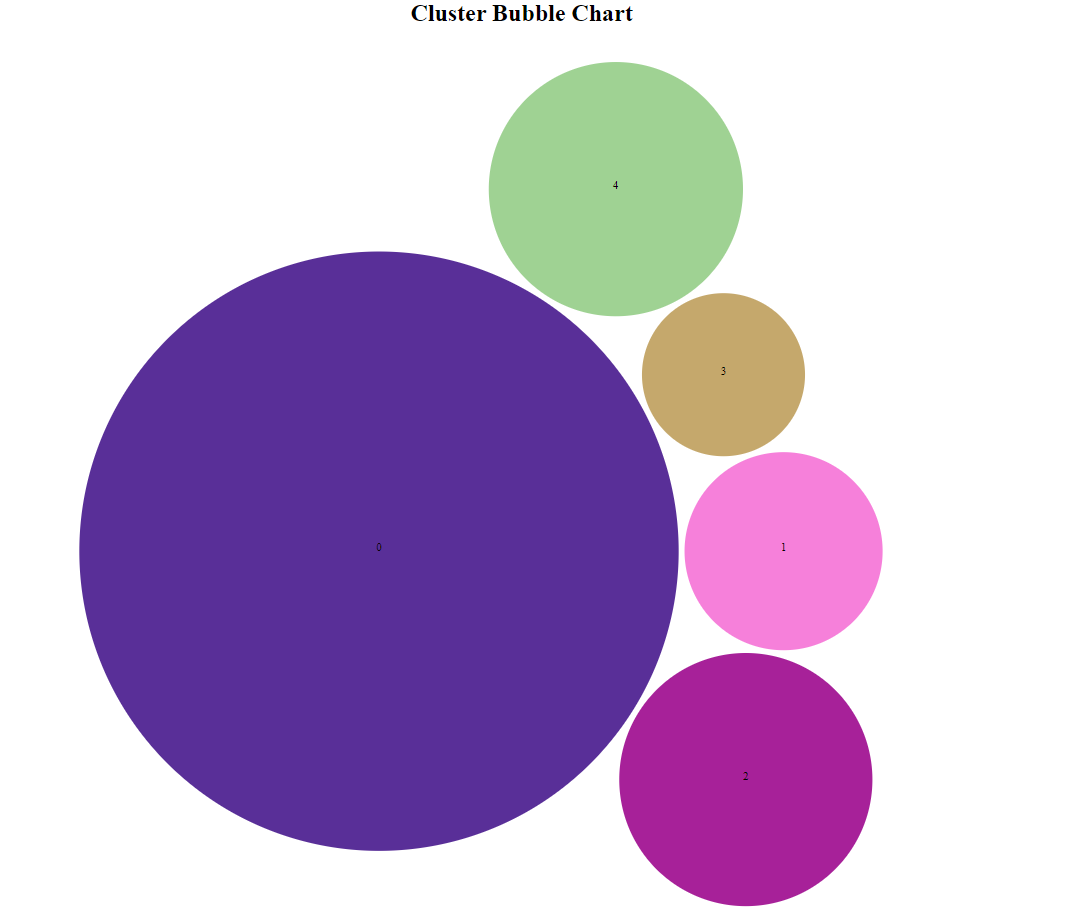

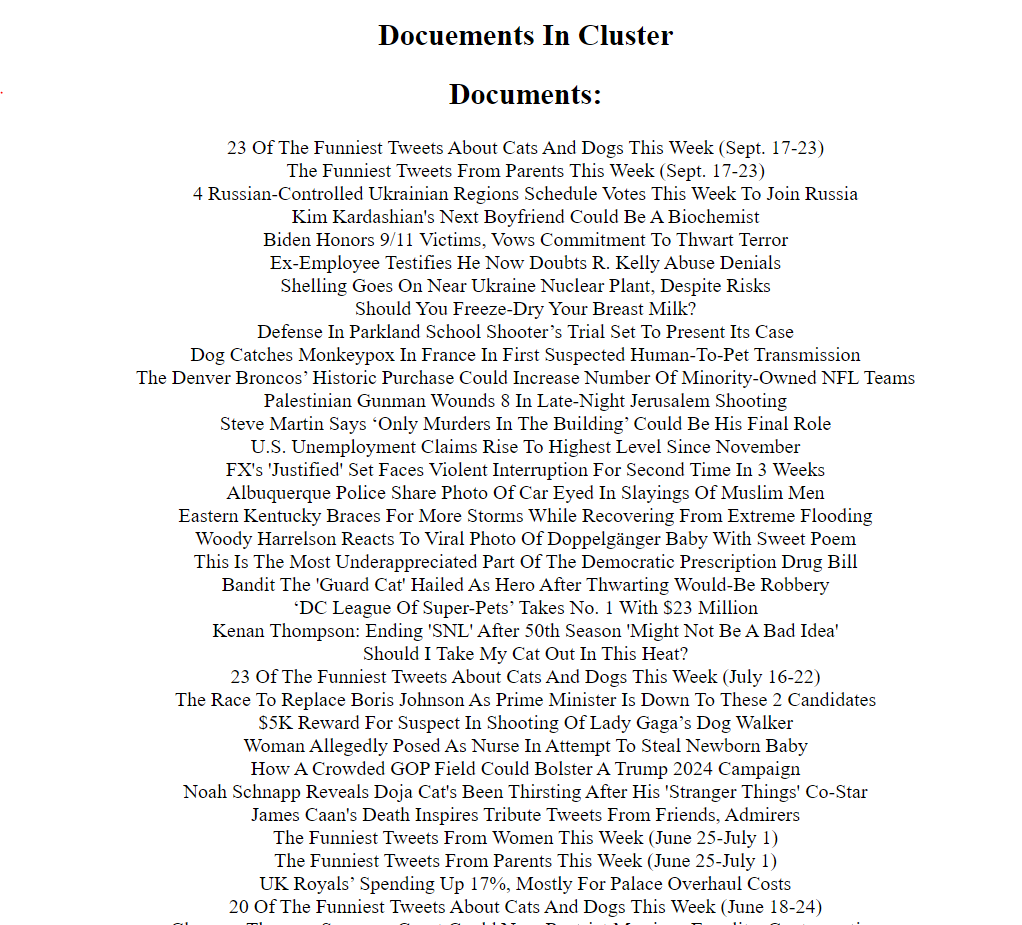
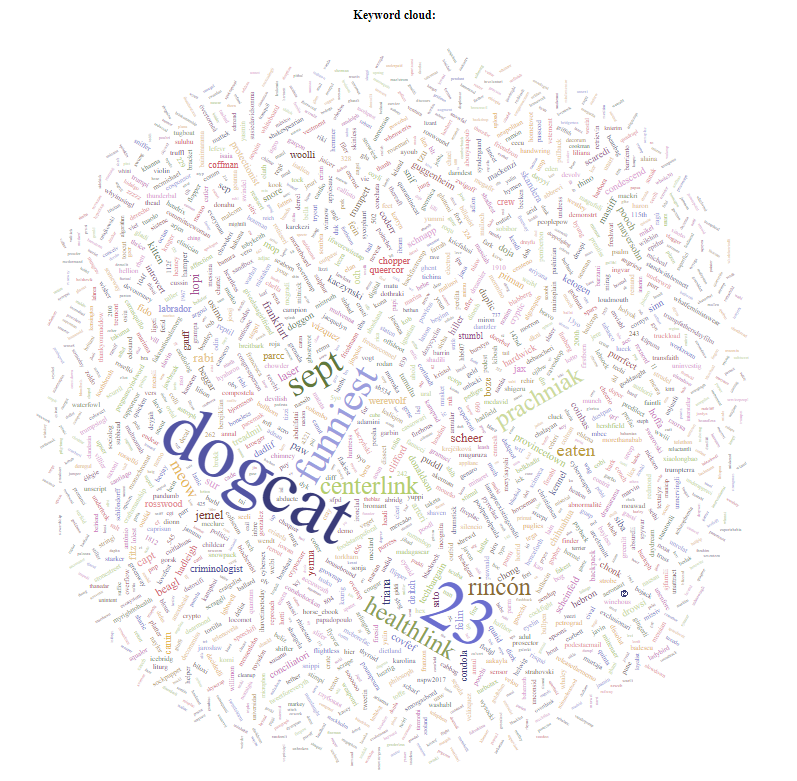